# Neural FCA

**Author:** Vladislav Pendishchuk

In [460]:
!pip install caspailleur==0.1.3
!pip install pydantic==1.10.13
!pip install fcapy==0.1.4.3
!pip install frozendict
!pip install ipynb
!pip install sparselinear
!pip install bitsets
!pip install bitarray==2.9.3

In [461]:
import random

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, classification_report, accuracy_score
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt
import neural_lib as nl
import torch
import networkx as nx
import collections

In [462]:
plt.rcParams['figure.facecolor'] = (1,1,1,1)

In [463]:
SEED = 112

np.random.seed(SEED)
random.seed(SEED)

## Concept network

### The dataset

I chose the Titanic passenger survival dataset, provided by Kaggle for learning purposes: https://www.kaggle.com/c/titanic/data.

The reasons why I chose this particular dataset are:
- the dataset has a relatively small amount of objects (891) and features (12 before clean up and binarization), which makes it manageable from both the perspective of computational complexity of FCA and the perspective of human understanding
- the dataset includes both categorical and numerical data

The features are:
- `PassengerId` - the ID of the passenger
- `Survived` - **the target feature**, 1 if survived, 0 if didn't survive
- `Pclass` - passenger class, a proxy for socio-economic status (SES)
- `Name`, `Sex`, `Age` - self-explanatory
- `SibSp` - the number of siblings & spouses aboard
- `Parch` - the number of parents & children aboard
- `Fare` - the passenger fare
- `Cabin` - the cabin number
- `Embarked` - the port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

Our goal is to learn to predict a passenger's survival.

In [464]:
df = pd.read_csv('data/Titanic-Dataset.csv')

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Feature preprocessing

In [465]:
df = df.drop(['Name', 'PassengerId', 'Ticket', 'Fare', 'Cabin'], axis=1)

In [466]:
# Dropping all rows with nans
df = df.dropna(axis=0, how='any')

In [467]:
df.shape

(712, 7)

First, we'll drop the following features:
- features `Name`, `PassengerId` and `Ticket` are all essentially identifiers, and are thus of no use to us for the purpose of classification
- the feature `Fare` roughly corresponds to the passenger's class in the context of survival analysis, so we'll treat this feature as a duplicate of `Pclass` and drop it to make things easier to interpret
- the feature `Cabin`, while not being an identifier, is close to being unique for most passengers, isn't an ordinal feature, and, when treated as a categorical feature, will generate dozens of features upon OHE - hence, we discard it

In [468]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


For `Age` I chose to use ordinal greater-than-or-equal scaling with the following thresholds: 18, 40, 60.

These thresholds were chosen as rough boundaries for major age groups: children [0;18), young adults [18;40), middle-aged adults [40;60) and senior adults [60;+inf). The greater-than-or-equal operator was chosen because the intervals for the aforementioned age groups are closed on the left.

In [469]:
df['Age >= 18'] = df['Age'] >= 18
df['Age >= 40'] = df['Age'] >= 40
df['Age >= 60'] = df['Age'] >= 60

df.drop('Age', inplace=True, axis=1)

Let's look at the distribution of features `SibSp` and `Parch`.

<Axes: xlabel='SibSp', ylabel='Count'>

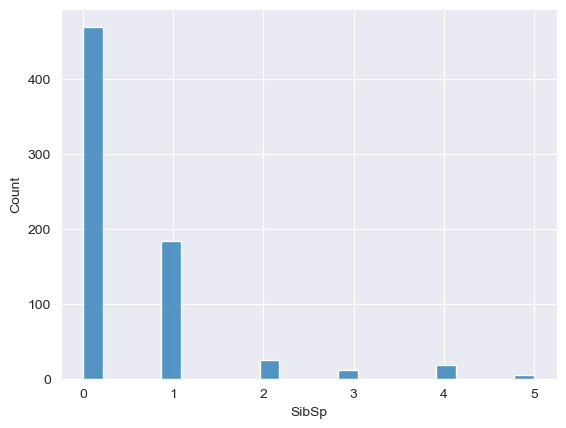

In [470]:
sns.histplot(df['SibSp'])

<Axes: xlabel='Parch', ylabel='Count'>

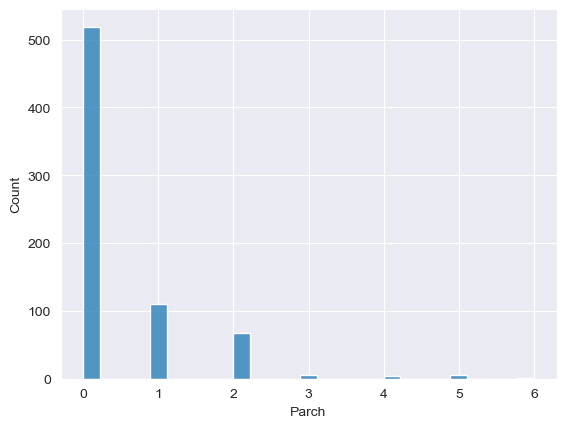

In [471]:
sns.histplot(df['Parch'])

For both features it seems that ordinal scaling with two thresholds - 1 and 2 - will suffice.

From the distribution one can see that most people came alone, some - with a single spouse/sibling, and a very small amount - with a spouse and a sibling (or two+ siblings). The same can be said about children & parents.

For ordinal scaling of these features I'll use the same operator as before ($\geq$), as I want loners (most people in the dataset) to not have any of these features. This will reduce the number of computations needed for FCA.

In [472]:
df['SibSp >= 1'] = df['SibSp'] >= 1
df['SibSp >= 2'] = df['SibSp'] >= 2

df['Parch >= 1'] = df['Parch'] >= 1
df['Parch >= 2'] = df['Parch'] >= 2

df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [473]:
df.nunique()

Survived      2
Pclass        3
Sex           2
Embarked      3
Age >= 18     2
Age >= 40     2
Age >= 60     2
SibSp >= 1    2
SibSp >= 2    2
Parch >= 1    2
Parch >= 2    2
dtype: int64

Lastly, the sake of clarity I'll map `Pclass` to string labels, to clearly emphasize this feature as categorical and make features after OHE easier to understand.

In [474]:
pclass_map = {
    1: '1st',
    2: '2nd',
    3: '3rd'
}

df['Pclass'] = df['Pclass'].map(pclass_map)

### Binarization

In [475]:
# Separating features from the target variable
target = 'Survived'

X = df.drop(target, axis=1)
y = df[target]

At this step we apply one-hot encoding (OHE) to binarize the resulting features.

In [476]:
X = pd.get_dummies(X)
X.head()

,Age >= 18,Age >= 40,Age >= 60,SibSp >= 1,SibSp >= 2,Parch >= 1,Parch >= 2,Pclass_1st,Pclass_2nd,Pclass_3rd,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,True,False,False,True,False,False,False,False,False,True,False,True,False,False,True
1,True,False,False,True,False,False,False,True,False,False,True,False,True,False,False
2,True,False,False,False,False,False,False,False,False,True,True,False,False,False,True
3,True,False,False,True,False,False,False,True,False,False,True,False,False,False,True
4,True,False,False,False,False,False,False,False,False,True,False,True,False,False,True


After binarizing the preprocessed dataset we obtain 15 features.

In [477]:
# Prepare train & test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [478]:
X_train.index = X_train.index.map(str)

### Concept networks

#### Building the concept networks

As 15 is a number of features that is pretty difficult to interpret in the context of FCA, I've decided to try building concept networks based on 4 different sets of features:
- all features;
- personal features - sex & age;
- passenger data - passenger class & port of embarkation;
- family-related data - `SibSp` & `Parch`.

To build each network we follow this algorithm:
- build a formal context based on the given list of features
- build a concept lattice: to do this I chose the faster alternative to CbO - the Sofia algorithm, as the CbO algorithm proved to be too slow to be able to build the concept lattice for the given dataset
- search for formal contexts with the highest F1 score, excluding the formal context the intent of which is equal to the full feature set, as including it when building the network leads to unexplainable architecture with a sole neuron above the output layer
- build the concept network based on the best concepts

In [479]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

In [480]:
def build_concept_network(train_X, train_y, concepts_count, print_logs=False):
    fc = FormalContext.from_pandas(train_X)
    if print_logs:
        print(fc)

    lat = ConceptLattice.from_context(fc, algo='Sofia', is_monotone=True)
    if print_logs:
        print('Concept count:', len(lat))

    # Calculating F1 score for each concept
    for concept in lat:
        concept_preds = np.zeros(fc.n_objects)
        concept_preds[list(concept.extent_i)] = 1
        
        # If the concept's intent is the full feature set, skip it to avoid confusing neural network architecture
        if len(concept.intent) == len(train_X.columns):
            concept.measures['f1_score'] = 0
        else:
            concept.measures['f1_score'] = f1_score(train_y, concept_preds)

    best_concepts = list(lat.measures['f1_score'].argsort()[::-1][:concepts_count])

    assert len({g_i for c in lat[best_concepts] for g_i in c.extent_i})==fc.n_objects, "Selected concepts do not cover all train objects"

    return nl.ConceptNetwork.from_lattice(lat, best_concepts, sorted(set(train_y)))

As it turned out during testing, it is impossible to build a concept network using only the family-related features set, as after excluding the concept with the full feature set intent, we are left with concepts that are insufficient to cover all train objects. Thus, this feature set was removed.

In [481]:
feature_sets = {
    'all': list(X_train.columns),
    'personal': ['Sex_male', 'Sex_female', 'Age >= 18', 'Age >= 40', 'Age >= 60'],
    'passenger_data': ['Pclass_1st', 'Pclass_2nd', 'Pclass_3rd', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
    #'family': ['SibSp >= 1', 'SibSp >= 2', 'Parch >= 1', 'Parch >= 2']
}

concepts_count = {
    'all': 28,
    'personal': 5,
    'passenger_data': 7,
    #'family': 20
}

In [482]:
concept_nets = {}

for key in feature_sets:
    print('=====================================================================')
    print('Building concept network for key %s' % key)
    
    train_X = X_train[feature_sets[key]]
    cn = build_concept_network(train_X, y_train, concepts_count[key], print_logs=True)
    concept_nets[key] = cn

Building concept network for key all
FormalContext (498 objects, 15 attributes, 2444 connections)
   |Age >= 18|Age >= 40|Age >= 60|SibSp >= 1|SibSp >= 2|...|Sex_female|Sex_male|Embarked_C|Embarked_Q|Embarked_S|
635|        X|         |         |          |          |...|         X|        |          |          |         X|
700|        X|         |         |         X|          |...|         X|        |         X|          |          |
296|        X|         |         |          |          |...|          |       X|         X|          |          |
398|        X|         |         |          |          |...|          |       X|          |          |         X|
504|         |         |         |          |          |...|         X|        |          |          |         X|
142|        X|         |         |         X|          |...|         X|        |          |          |         X|
7  |         |         |         |         X|         X|...|          |       X|          |          |  

#### Visualizing concept network architecture

Now let's visualize the obtained concept network architectures for each feature set. On the displayed plots one can see that practically none of these architectures look "explainable", as there are simply too many conceptual connections between the features. The full feature set architecture is particularly difficult to interpret.

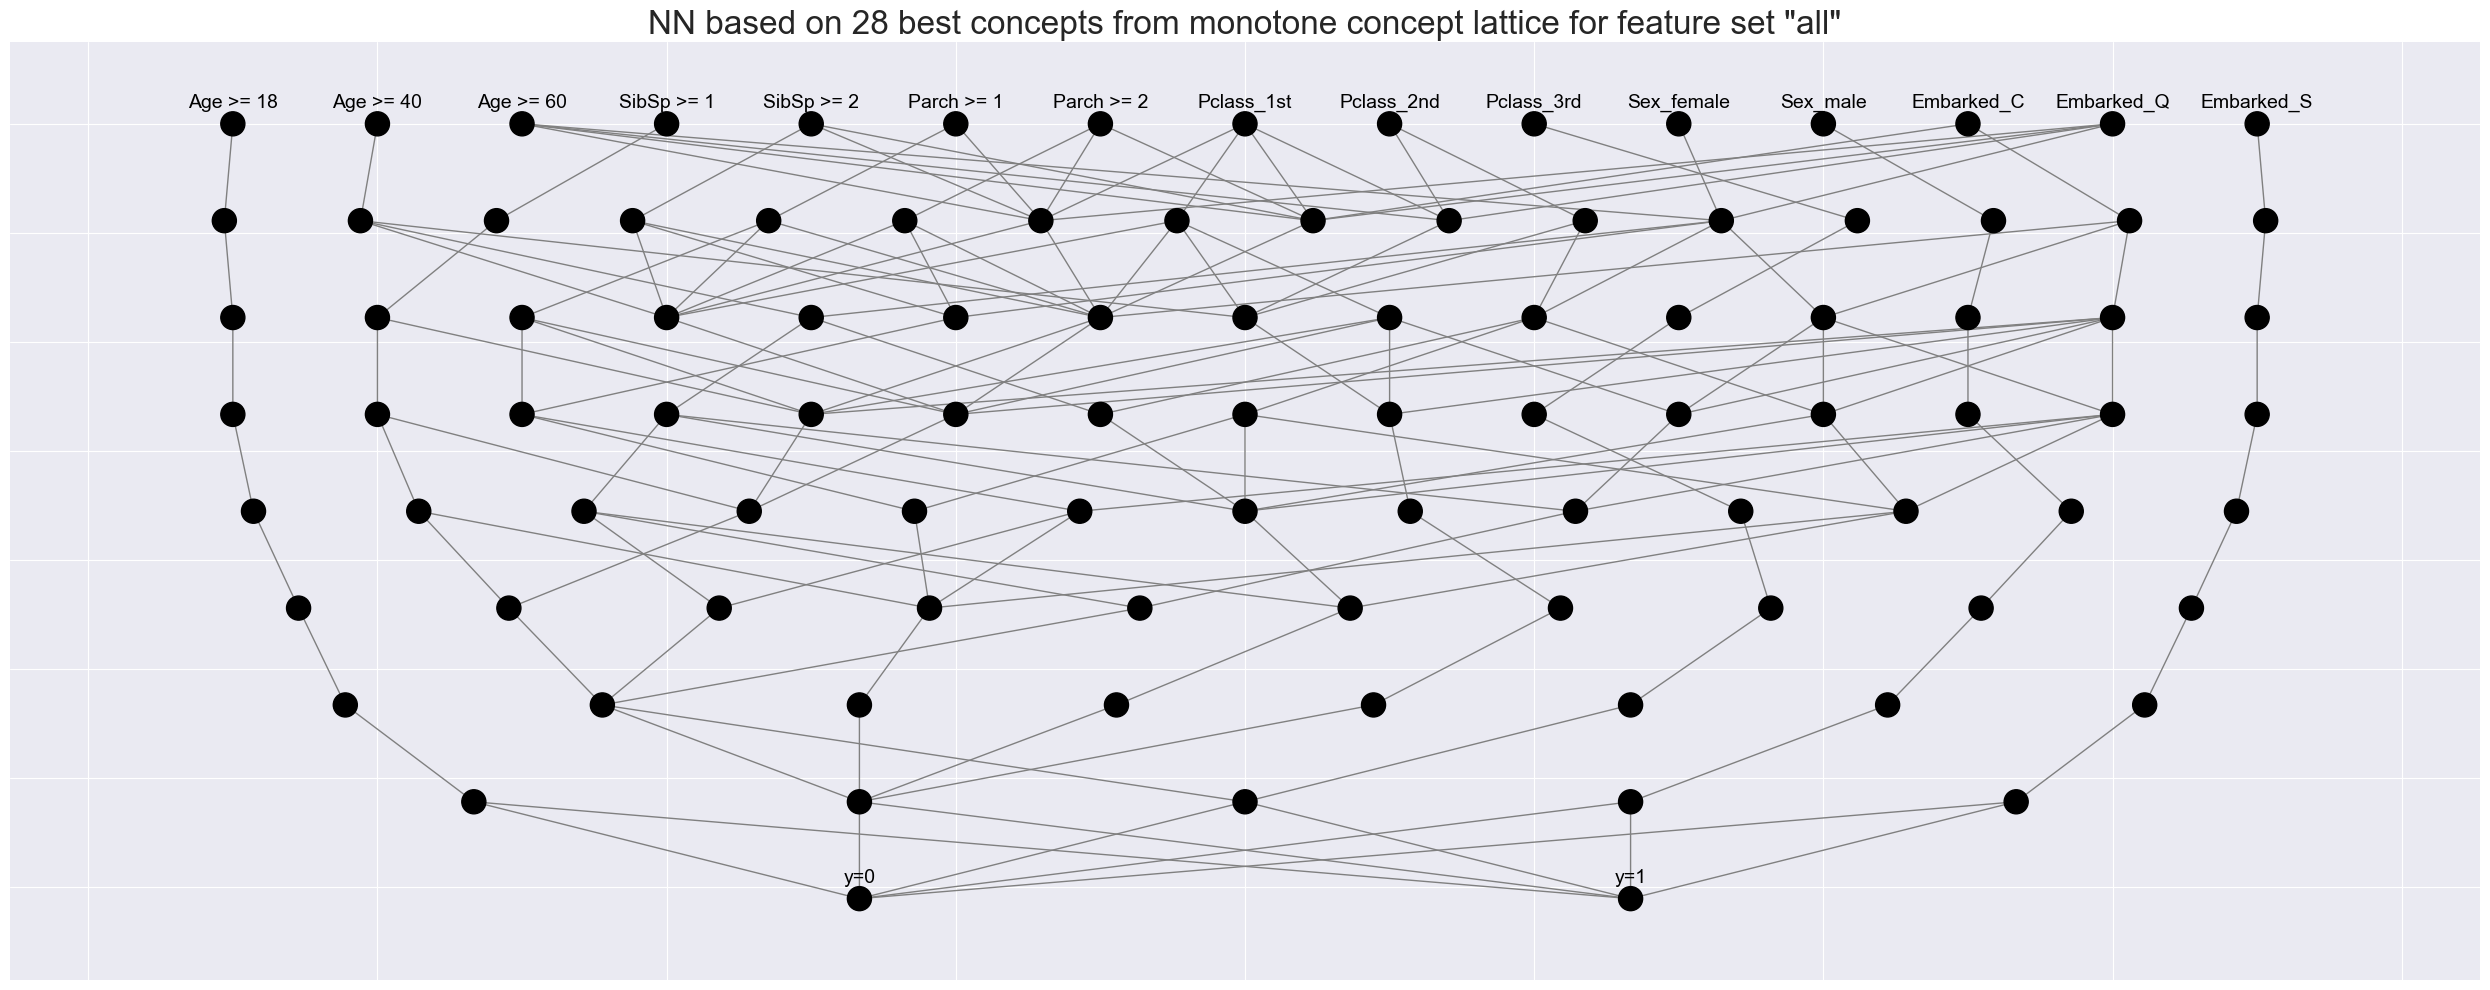

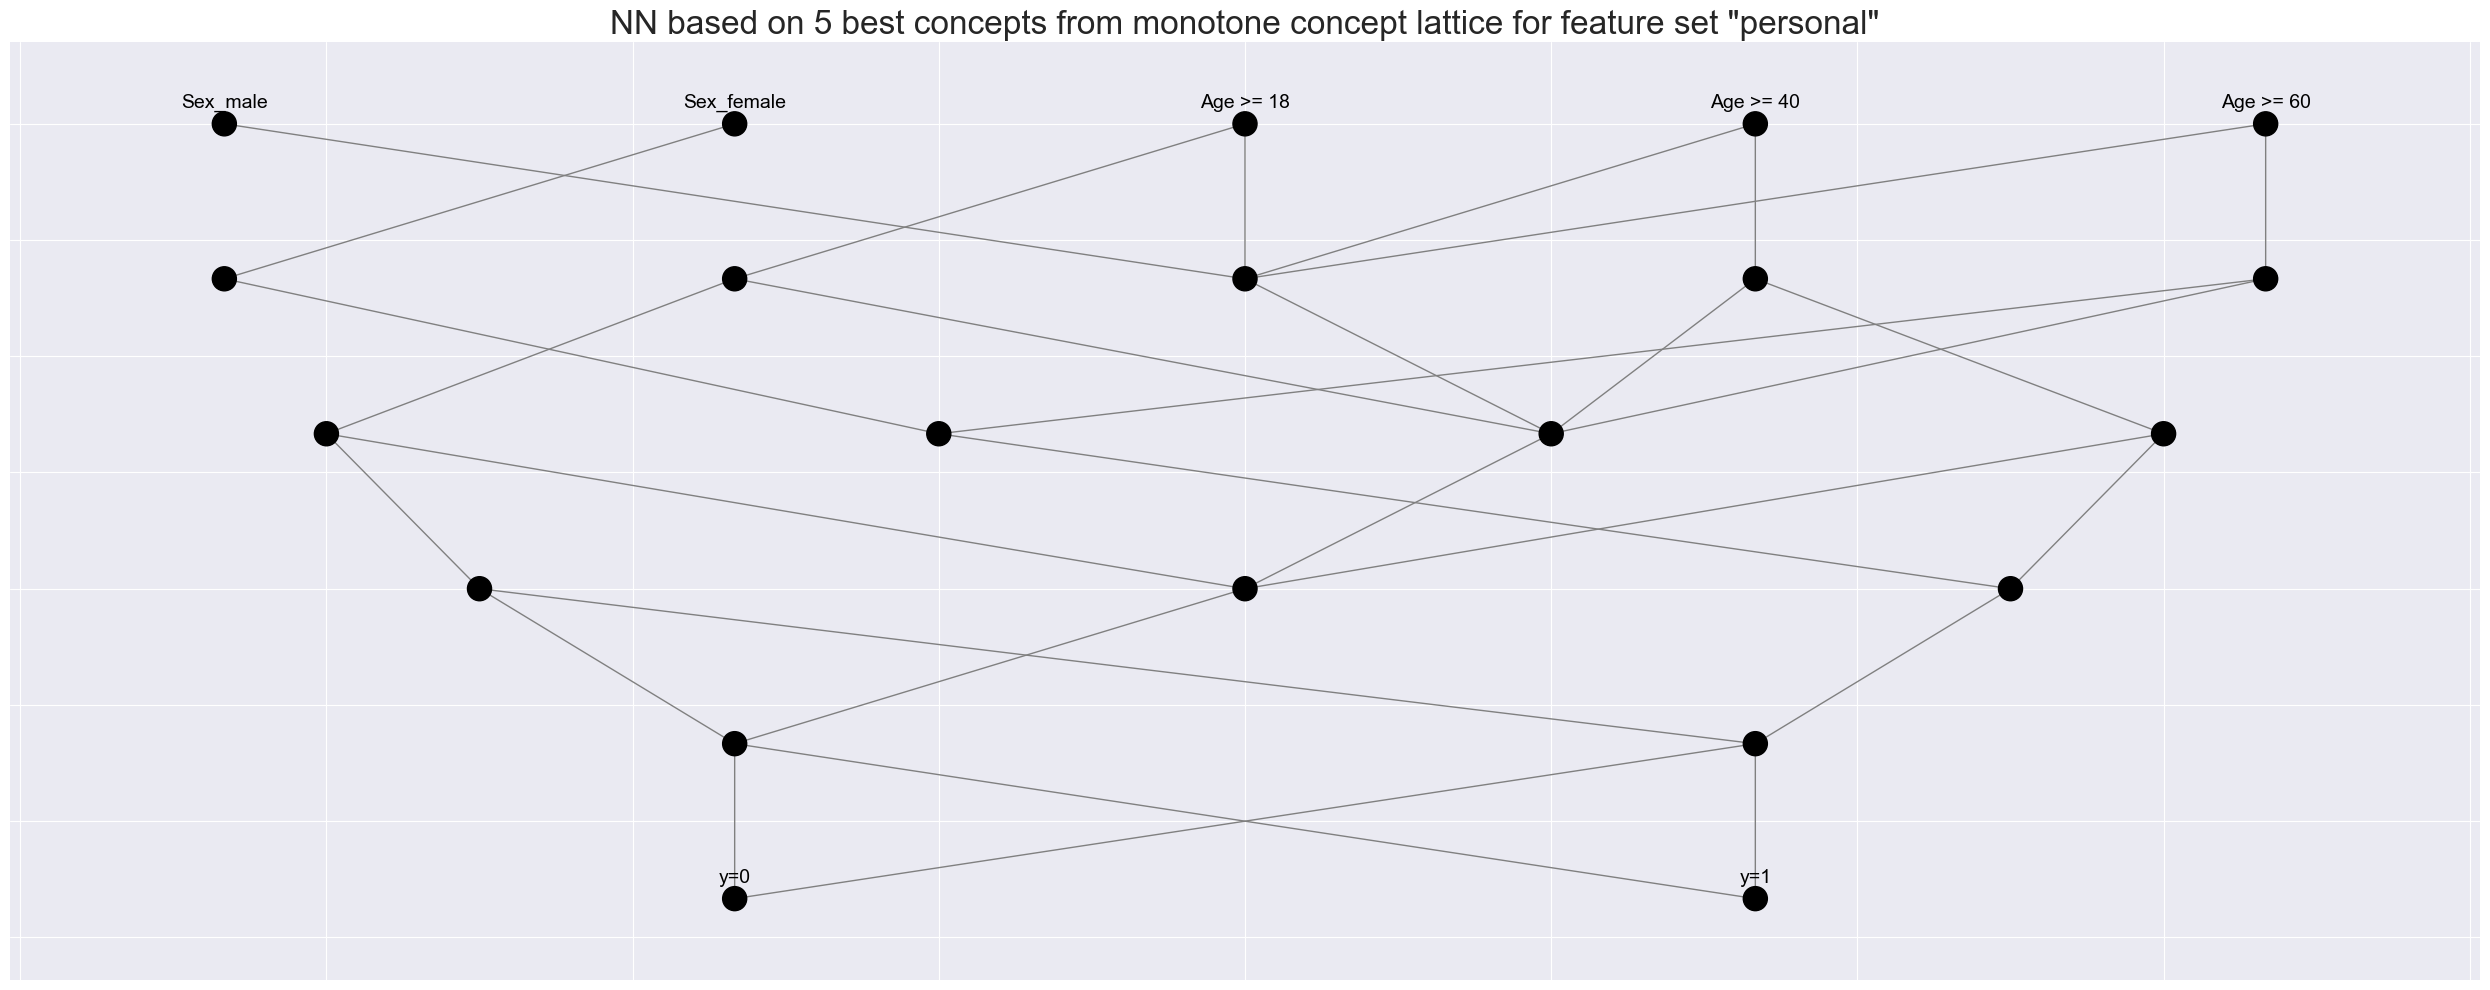

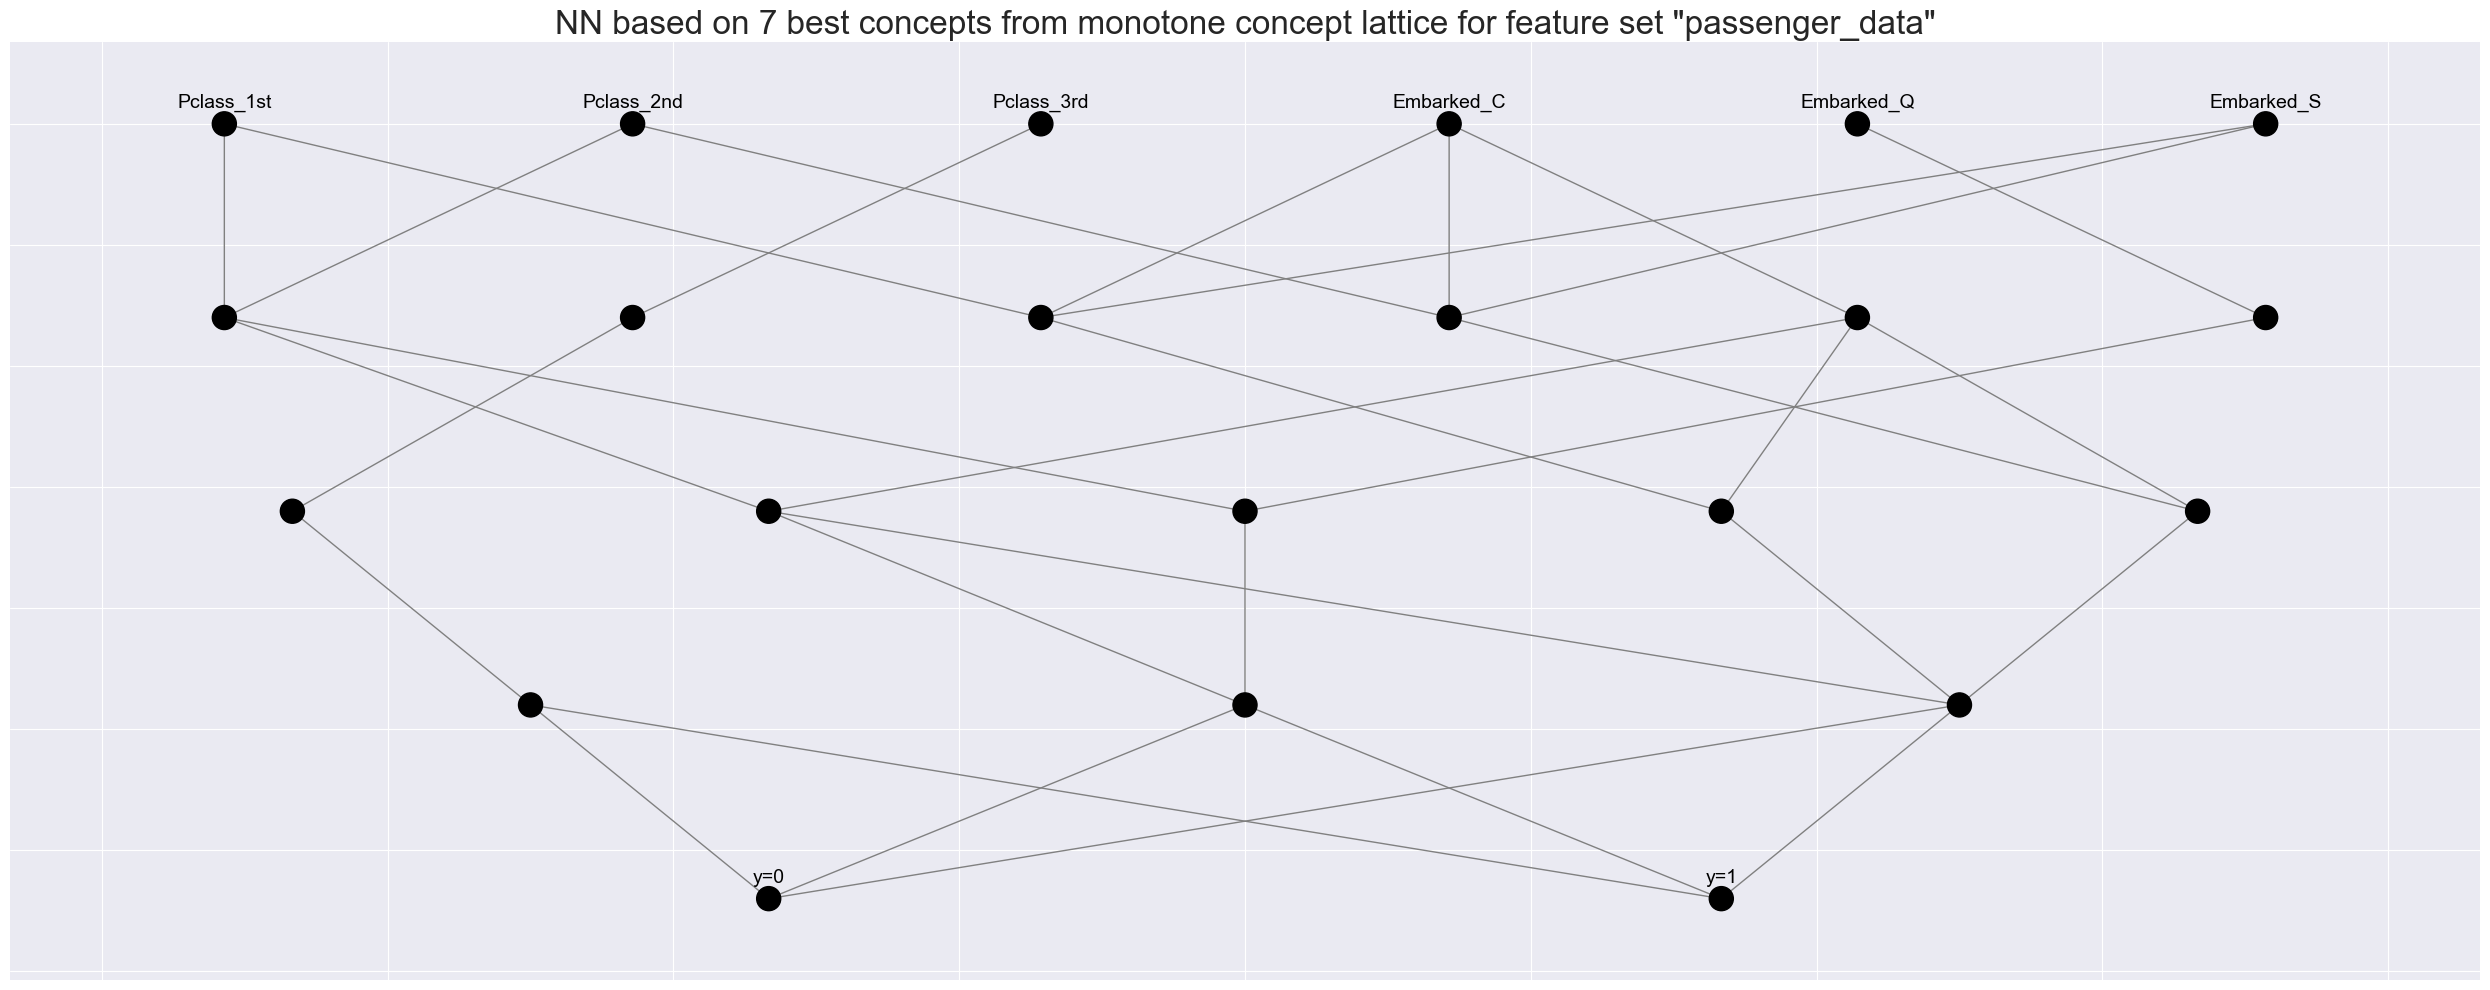

In [439]:
for key in concept_nets:
    net = concept_nets[key]
    conc_count = concepts_count[key]

    vis = LineVizNx(
        node_label_font_size=14,
        node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(net.attributes))+'\n\n',
        edge_cmap="hsv"
    )

    fig, ax = plt.subplots(figsize=(25, 10))

    vis.draw_poset(
        net.poset, ax=ax, edge_color='grey',
        flg_node_indices=False,
        node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(net.attributes), only_new_attrs=True)+'\n\n',
        node_color='black',
    )

    plt.title(f'NN based on {conc_count} best concepts from monotone concept lattice for feature set "{key}"', loc='center', size=24)

    plt.subplots_adjust()
    plt.tight_layout()
    plt.savefig(f'{key}.png')
    plt.show()

#### Evaluating concept networks

Now let's fit each concept network using different non-linearities:
- GELU (Gaussian Error Linear Unit)
- leaky ReLU (Rectified Linear Unit)
- hyperbolic tangent

In [440]:
nonlinearities = {
    'GELU': torch.nn.GELU,
    'LeakyReLU': torch.nn.LeakyReLU,
    'Tanh': torch.nn.Tanh
}

results = {
    'Feature set': [],
    'GELU': [],
    'LeakyReLU': [],
    'Tanh': []
}

In [441]:
cns = collections.defaultdict(dict)

In [442]:
best_f1_score = 0
best_acc_score = 0
best_key = None
best_nonlinearity = None

counter = 0
total = len(feature_sets) * len(nonlinearities)

for key in feature_sets:
    train_X = X_train[feature_sets[key]]
    
    results['Feature set'].append(key)
    
    for nonlinearity_name in nonlinearities:
        counter += 1
        
        print('=====================================================================')
        print(f'Fitting concept network for key {key}, non-linearity {nonlinearity_name}')
        print(f'Step {counter} / {total}')

        cn = build_concept_network(train_X, y_train, concepts_count[key], print_logs=False)
    
        cn.fit(train_X, y_train, n_epochs=4000, nonlinearity=nonlinearities[nonlinearity_name])
        y_preds = cn.predict(X_test[feature_sets[key]]).numpy()
    
        macro_f1_score = f1_score(y_test, y_preds, average='macro', zero_division=1.0)
        acc_score = accuracy_score(y_test, y_preds)

        cns[key][nonlinearity_name] = cn
        results[nonlinearity_name].append(macro_f1_score)

        if macro_f1_score > best_f1_score:
            best_f1_score = macro_f1_score
            best_acc_score = acc_score
            best_nonlinearity = nonlinearity_name
            best_key = key

Fitting concept network for key all, non-linearity GELU
Step 1 / 9
Fitting concept network for key all, non-linearity LeakyReLU
Step 2 / 9
Fitting concept network for key all, non-linearity Tanh
Step 3 / 9
Fitting concept network for key personal, non-linearity GELU
Step 4 / 9
Fitting concept network for key personal, non-linearity LeakyReLU
Step 5 / 9
Fitting concept network for key personal, non-linearity Tanh
Step 6 / 9
Fitting concept network for key passenger_data, non-linearity GELU
Step 7 / 9
Fitting concept network for key passenger_data, non-linearity LeakyReLU
Step 8 / 9
Fitting concept network for key passenger_data, non-linearity Tanh
Step 9 / 9


In [443]:
df_results = pd.DataFrame(results)
print(df_results)

      Feature set      GELU  LeakyReLU      Tanh
0             all  0.721139   0.738858  0.727658
1        personal  0.760905   0.748826  0.760905
2  passenger_data  0.588988   0.588988  0.588988


In [444]:
print(f'Best macro F1 score achieved at feature set "{best_key}" with non-linearity {best_nonlinearity} - F1: {best_f1_score:.4f}, accuracy: {best_acc_score:.4f}')

Best macro F1 score achieved at feature set "personal" with non-linearity GELU - F1: 0.7609, accuracy: 0.7850


#### Visualizing trained weights

In [445]:
nets = dict(cns)

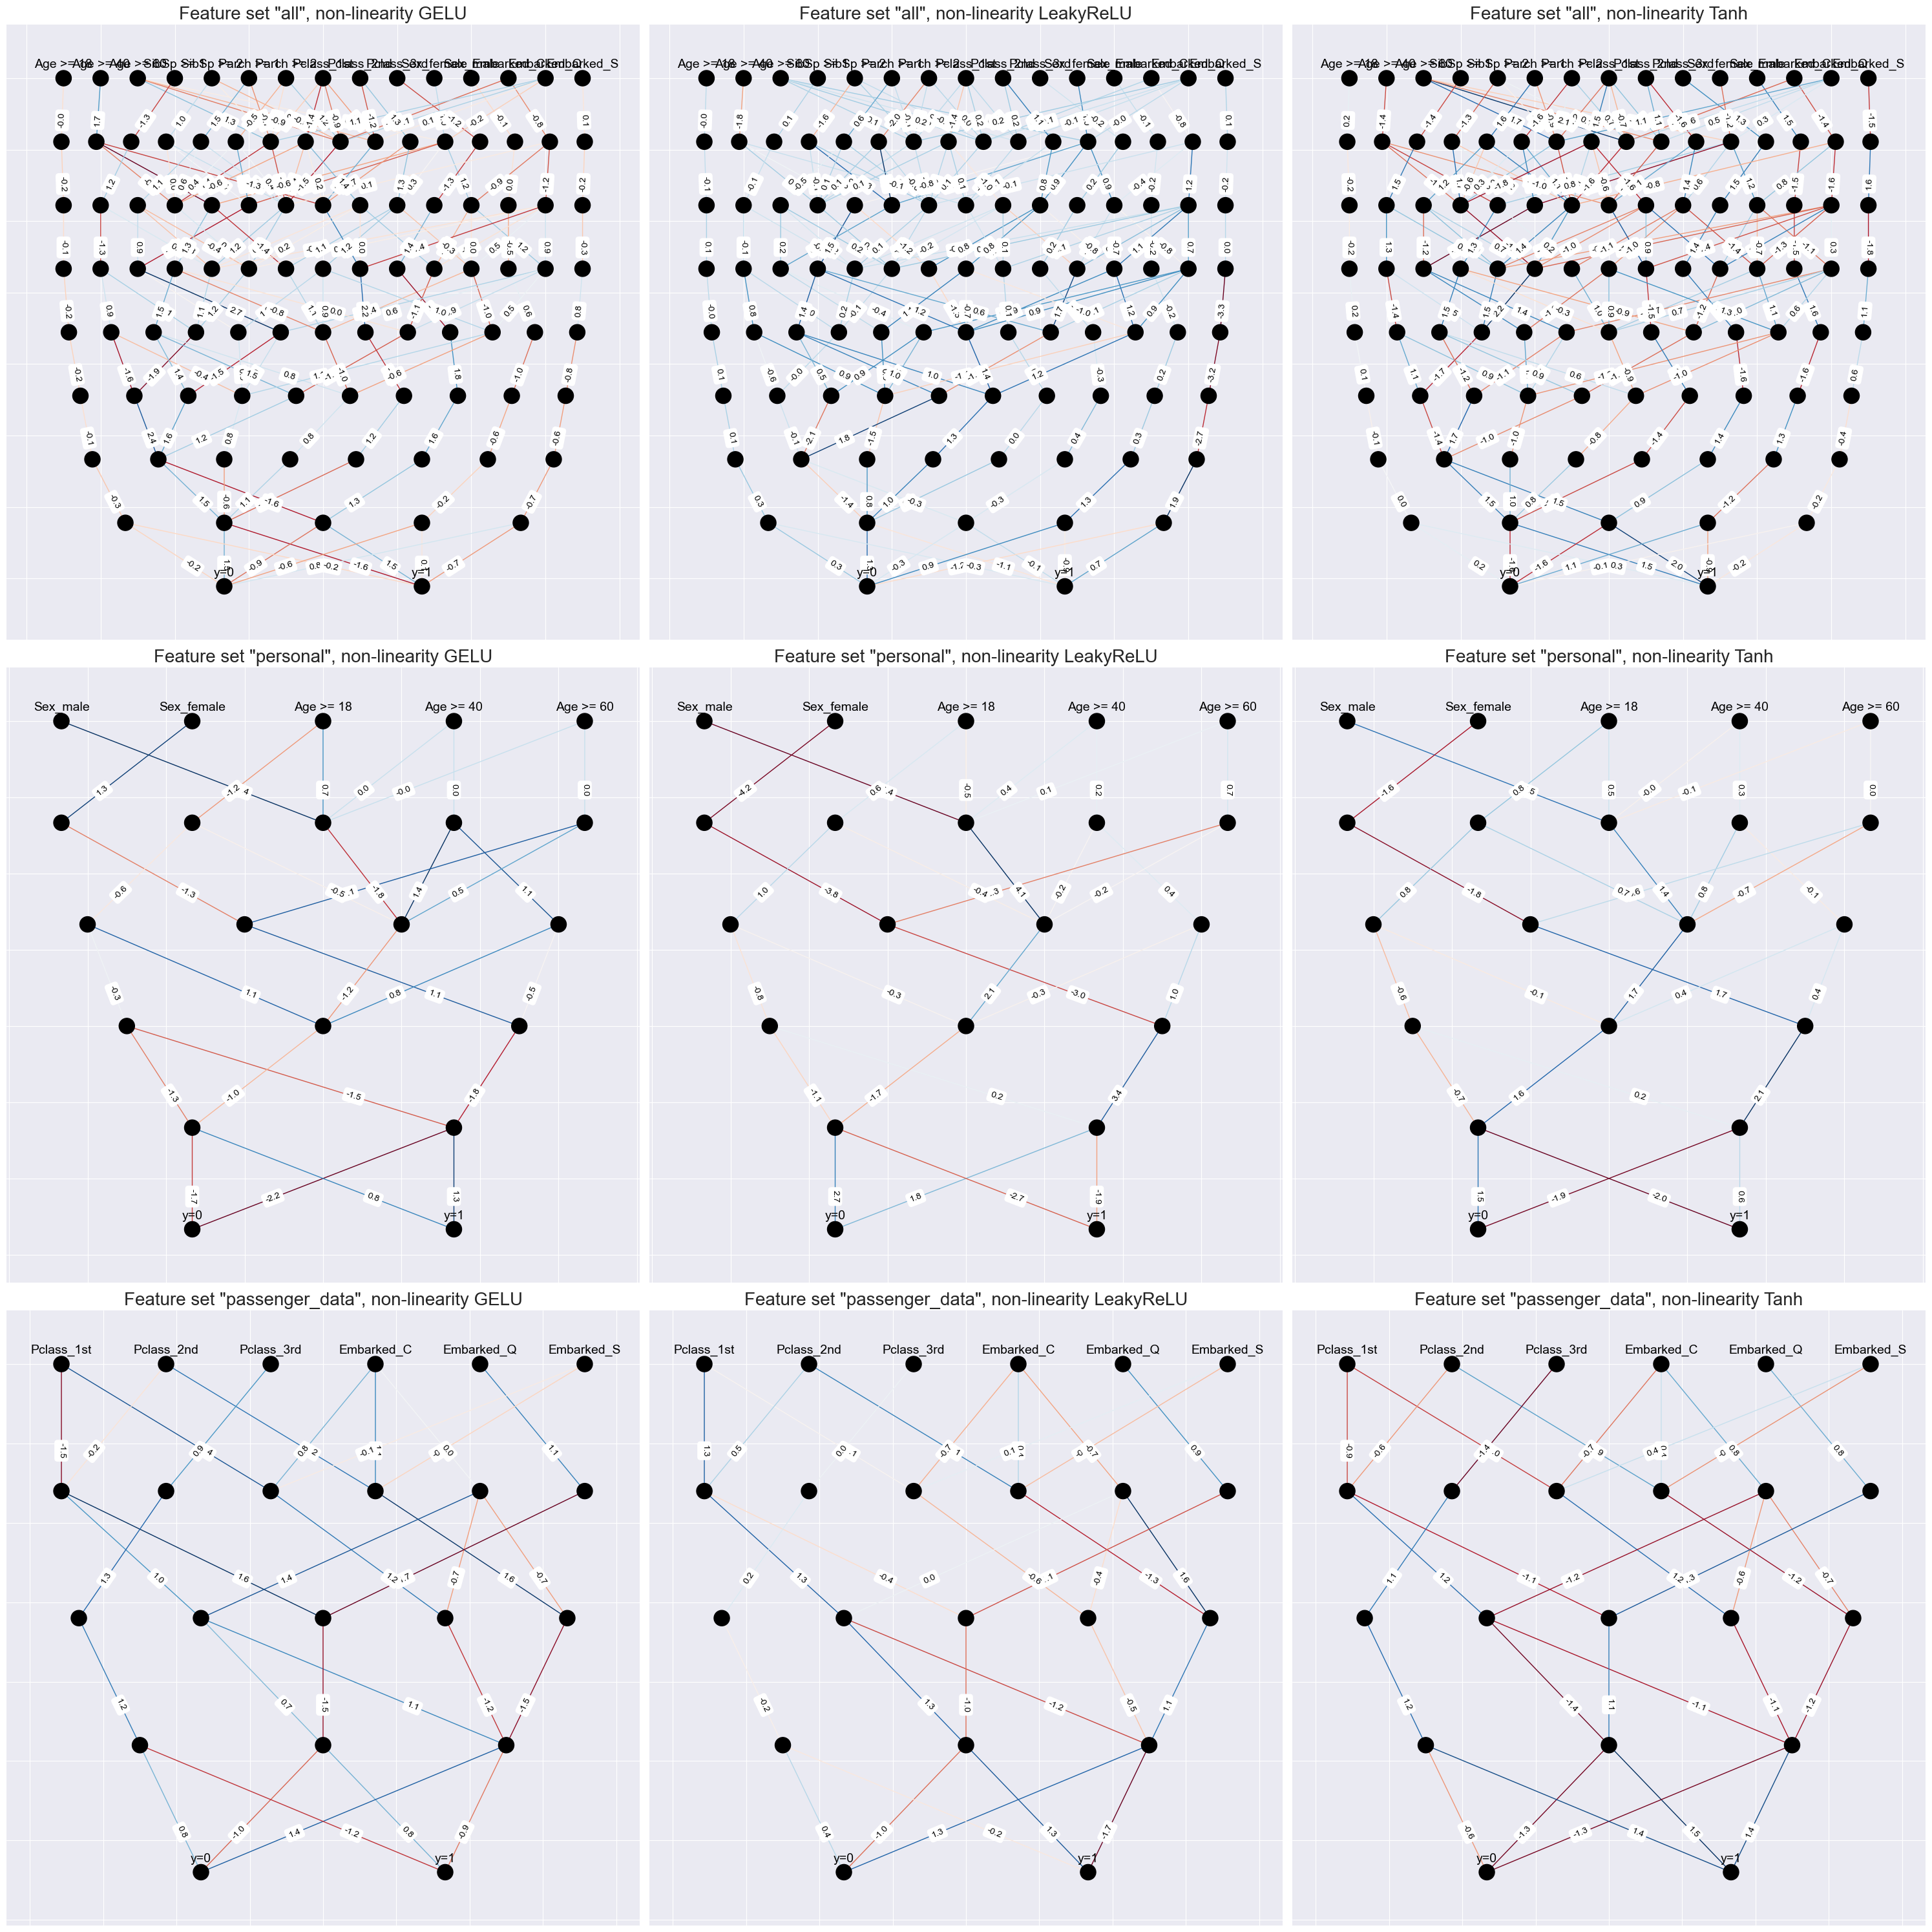

In [446]:
fig, axs = plt.subplots(3, 3, figsize=(30,30))

row = 0
col = 0

for feature_set_key in nets:
    for nonlinearity_name in nets[feature_set_key]:
        net = nets[feature_set_key][nonlinearity_name]
        
        edge_weights = net.edge_weights_from_network()

        vis = LineVizNx(
            node_label_font_size=14,
            node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(net.attributes))+'\n\n',
            edge_cmap="hsv"
        )
    
        # Drawing the concept network poset
        vis.draw_poset(
            net.poset, ax=axs[row, col], node_color='black',
            flg_node_indices=False,
            node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(net.attributes), only_new_attrs=True)+'\n\n',
            edge_color=[edge_weights[edge] for edge in net.poset.to_networkx().edges],
            edge_cmap=plt.cm.RdBu,
        )
        # Displaying the weights
        nx.draw_networkx_edge_labels(net.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7, ax=axs[row, col])
    
        axs[row, col].set_title(f'Feature set "{feature_set_key}", non-linearity {nonlinearity_name}', size=20, loc='center')
        
        col = (col + 1) % 3
        
    row = (row + 1) % 3

plt.tight_layout()
plt.subplots_adjust()
plt.show()

## Classic ML methods

Now let's apply several classic ML algorithms to the same problem in order to compare their performance to the performance of the best obtained concept network.

The following algorithms were tested:
- Gaussian Naive Bayes;
- KNN;
- Logistic Regression;
- Decision Tree Classifier;
- Random Tree Classifier;
- XGBoost.

In [447]:
train_indices = X_train.index.astype(int)
test_indices = X_test.index.astype(int)

In [448]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

In [449]:
ml_df = pd.read_csv('data/Titanic-Dataset.csv')

ml_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Feature preprocessing

The aforementioned ML algorithms do not require us to binarize the features, and most of them are better suited to work with numerical data (some of them, e.g. KNN, practically support only numerical data). Because of this, we will preprocess the features in the following way:
- transform all the categorical features into a number of numerical features via OHE
- standardize all the features (which are now all numerical) by applying `StandardScaler`

Just as before, we will discard the features `Name`, `PassengerId`, `Ticket`, `Fare` and `Cabin`.

In [450]:
ml_df = ml_df.drop(['Name', 'PassengerId', 'Ticket', 'Fare', 'Cabin'], axis=1)

In [451]:
# Dropping all rows with nans
ml_df = ml_df.dropna(axis=0, how='any')

In [452]:
ml_X = ml_df.drop(target, axis=1)
ml_y = ml_df[target]

In [453]:
# One-hot encoding the categorical features
ml_X = pd.get_dummies(ml_X, columns=['Pclass', 'Sex', 'Embarked'], dtype=int)

In [454]:
ml_X_train = ml_X.loc[train_indices]
ml_y_train = ml_y.loc[train_indices]

ml_X_test = ml_X.loc[test_indices]
ml_y_test = ml_y.loc[test_indices]

In [455]:
# Standardizing the features
scaler = StandardScaler()
scaler.fit(ml_X_train)

ml_X_train = scaler.transform(ml_X_train)
ml_X_test = scaler.transform(ml_X_test)

In [456]:
ml_X_train[:5]

array([[-0.07116398, -0.55335375, -0.52832587, -0.57271284,  1.72742583,
        -1.00402416,  1.27320565, -1.27320565, -0.48236217, -0.21498485,
         0.551058  ],
       [-0.7701573 ,  0.49844078, -0.52832587,  1.74607574, -0.57889606,
        -1.00402416,  1.27320565, -1.27320565,  2.07313105, -0.21498485,
        -1.81469101],
       [-0.38571097, -0.55335375, -0.52832587, -0.57271284, -0.57889606,
         0.99599197, -0.78541907,  0.78541907,  2.07313105, -0.21498485,
        -1.81469101],
       [-0.42066064, -0.55335375, -0.52832587, -0.57271284,  1.72742583,
        -1.00402416, -0.78541907,  0.78541907, -0.48236217, -0.21498485,
         0.551058  ],
       [-0.90995596, -0.55335375, -0.52832587,  1.74607574, -0.57889606,
        -1.00402416,  1.27320565, -1.27320565, -0.48236217, -0.21498485,
         0.551058  ]])

### Training the models

To train the selected models, we will utilize sklearn's `GridSearchCV` to tune each model's hyperparameters. As we're performing binary classification, we'll use macro F1 as the scoring function for cross-validation.

In [457]:
results = {
    'Model': [],
    'Accuracy': [],
    'Macro F1': [],
}

models = {
    'KNN': KNeighborsClassifier(),
    'LogReg': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', objective='binary:logistic'),
    'Gaussian NB': GaussianNB()
}

# The hyperparameter grid for each algorithm
param_grid = {
    'KNN': {
        'n_neighbors': [3, 5, 7, 10],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'LogReg': {
        'C': [0.1, 1, 10]
    },
    'DecisionTree': {
        'max_depth': [None, 5, 7, 10]
    },
    'RandomForest': {
        'n_estimators': [10, 20, 35, 50],
        'max_depth': [None, 2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.2],
        'max_depth': [3, 5],
        'min_child_weight': [1, 3],
        'subsample': [0.8, 1.0],
    },
    'Gaussian NB': {
        'var_smoothing': [1e-9, 1e-8, 1e-7]
    }
}

In [458]:
for key in models:
    model = models[key]
    params = param_grid[key]

    clf = GridSearchCV(model, params, verbose=1, scoring='f1_macro')
    clf.fit(ml_X_train, ml_y_train)

    accuracy_score = cross_val_score(clf.best_estimator_, ml_X_test, ml_y_test, cv=5, scoring='accuracy')
    f1_score = cross_val_score(clf.best_estimator_, ml_X_test, ml_y_test, cv=5, scoring='f1_macro')
    
    results['Model'].append(key)
    results['Accuracy'].append(round(accuracy_score.mean(), 3))
    results['Macro F1'].append(round(f1_score.mean(), 3))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [459]:
# Printing the results
df_results = pd.DataFrame(results)
print(df_results)

          Model  Accuracy  Macro F1
0           KNN     0.804     0.774
1        LogReg     0.790     0.760
2  DecisionTree     0.804     0.773
3  RandomForest     0.836     0.807
4       XGBoost     0.781     0.755
5   Gaussian NB     0.683     0.654
